# Group 21  - Chess Piece Classification
## Deep Learning Project


|      |     Student Name     |     Student Email    | 
|---   |         ---          |           ---          |
| 1    |      Ana Miguel Sal       |20221645@novaims.unl.pt| 
| 2    |      David Castro      |          20220688@novaims.unl.pt    | 
| 3    |      Ehis Jegbefumwen        |20221015@novaims.unl.pt| 
| 4    |      Evans Onorieru|        20220657@novaims.unl.pt     | 
| 5    |      Ricardo Montenegro      |20221359@novaims.unl.pt| 

### Data Source
https://www.kaggle.com/datasets/s4lman/chess-pieces-dataset-85x85

### Abstract

This file presents the transfer learning part. We used our pre-trained model CNN-V2 that was accurated by Random Search as the starting point to go again through the training and validation dataset. This will allows us to leverage the knowledge learned from a large dataset to a new dataset with a similar problem. In the end we end up using this new model on our test dataset.


## 1. Imports

In [ ]:
# Install keras-tuner
!pip install keras-tuner #comment if it is already install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import shutil
import zipfile

from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics, losses
import numpy as np

import os
from PIL import Image, ImageEnhance
import glob
import random

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory 
import tensorflow as tf

import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers

from kerastuner import HyperParameters
from kerastuner.tuners import Hyperband
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

## 2. Load Images

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = '/content/drive/MyDrive/NOVA IMS/DL/project/'
main_folder = "data/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'archive.zip', 'archive.zip')
    # Extract files
    zip_ = zipfile.ZipFile('archive.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 0.257 seconds


## 3. Data Preprocessing

*   Data Augmentation
*   Save those new images to create a new balanced dataset



In [ ]:
# Creation of an augmentation pipeline

augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.25),
                           layers.RandomBrightness(factor=0.2),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

Create a function that loops for each image in each of the subfolders and create a modify version of each image (trials) times. Then each of the new image created is then saved in the same folder of the existing original image.

In [ ]:

def augment_images(folder_path, trials):
    # create an instance of the image data generator with your augmentation pipeline
    datagen = ImageDataGenerator(preprocessing_function=augmentation)

    # get a list of all image filenames in the folder
    image_filenames = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    # loop through each image file
    for filename in image_filenames:
        # open the image file
        image_path = os.path.join(folder_path, filename)
        with Image.open(image_path) as image:
            # expand the image dimension and apply augmentation pipeline 'trials' times
            x = np.expand_dims(np.array(image), axis=0)
            for i in range(trials):
                # generate an augmented image
                augmented_image = datagen.flow(x, batch_size=1)[0][0]

                # save the augmented image with a new filename
                new_filename = f'{os.path.splitext(filename)[0]}_augmented_{i}.jpg'
                new_image_path = os.path.join(folder_path, new_filename)
                Image.fromarray(augmented_image.astype('uint8')).save(new_image_path)

    print('Image augmentation complete!')


Run this function for all subfolders, except for the 'pawn' folder.

In [ ]:
augment_images('/content/data/bishop', 4)
augment_images('/content/data/king', 7)
augment_images('/content/data/knight', 4)
augment_images('/content/data/queen', 7)
augment_images('/content/data/rook', 4)


Image augmentation complete!
Image augmentation complete!
Image augmentation complete!
Image augmentation complete!
Image augmentation complete!


Count how many images each subfolder has:

In [ ]:
# Set the path to the dataset directory
dataset_path = path + main_folder

# Get a list of subdirectories (i.e., class folders) in the dataset directory
subdirs = glob.glob(os.path.join(dataset_path, '*'))

# Loop through each subdirectory and count the number of images
for subdir in subdirs:
    num_images = len(os.listdir(subdir))
    print('Class {}: {} images'.format(os.path.basename(subdir), num_images))

Class queen: 272 images
Class bishop: 335 images
Class knight: 355 images
Class pawn: 239 images
Class king: 272 images
Class rook: 360 images


Limit all subfolder to a maximum of 239 images, randomly sorted.

In [ ]:
# set the path to the folder containing the class folders
parent_folder = '/content/data/'

# set the desired number of images for each class
num_images_per_class = 239

# loop through each class folder
for class_folder in os.listdir(parent_folder):
    # set the path to the current class folder
    class_folder_path = os.path.join(parent_folder, class_folder)
    # check if it is a folder and not a file
    if os.path.isdir(class_folder_path):
        # get a list of all image filenames in the folder
        image_filenames = [f for f in os.listdir(class_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
        # shuffle the image filenames
        random.shuffle(image_filenames)
        # loop through the excess images and remove them
        for filename in image_filenames[num_images_per_class:]:
            file_path = os.path.join(class_folder_path, filename)
            os.remove(file_path)
        # print the number of images remaining in the folder
        num_images = len(os.listdir(class_folder_path))
        print(f'Class {class_folder}: {num_images} images')
print('Our dataset is now balanced!')


Class queen: 239 images
Class bishop: 239 images
Class knight: 239 images
Class pawn: 239 images
Class king: 239 images
Class rook: 239 images
Our dataset is now balanced!


## 4. Changing the architecture of the dataset - Train and Test Split

1.   Train and validation Split
2.   Set ds_train, ds_val, ds_test



Split the image dataset into Train and Test data by changing organization/structure of the folders.

In [ ]:
# Set path to your data folder
data_path = path + main_folder

# Set path to your destination folder
destination_path = path

# Set test data size (fraction)
test_size = 0.2

# Create destination folders
train_path = os.path.join(destination_path, "training_data")
os.makedirs(train_path, exist_ok=True)

test_path = os.path.join(destination_path, "testing_data")
os.makedirs(test_path, exist_ok=True)

# Loop through each class folder in data folder
for class_folder in os.listdir(data_path):
    class_folder_path = os.path.join(data_path, class_folder)

    # Split files into train and test sets
    files = os.listdir(class_folder_path)
    train_files, test_files = train_test_split(files, test_size=test_size)

    # Copy train files to destination folder
    train_class_folder = os.path.join(train_path, class_folder)
    os.makedirs(train_class_folder, exist_ok=True)
    for file_name in train_files:
        file_path = os.path.join(class_folder_path, file_name)
        shutil.copy(file_path, train_class_folder)

    # Copy test files to destination folder
    test_class_folder = os.path.join(test_path, class_folder)
    os.makedirs(test_class_folder, exist_ok=True)
    for file_name in test_files:
        file_path = os.path.join(class_folder_path, file_name)
        shutil.copy(file_path, test_class_folder)


Confirm if the cell above was successfully acomplished.

In [ ]:
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    print(f"Train - {folder}: {len(os.listdir(folder_path))} files")

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    print(f"Test - {folder}: {len(os.listdir(folder_path))} files")


Train - queen: 191 files
Train - bishop: 191 files
Train - knight: 191 files
Train - pawn: 191 files
Train - king: 191 files
Train - rook: 191 files
Test - queen: 48 files
Test - bishop: 48 files
Test - knight: 48 files
Test - pawn: 48 files
Test - king: 48 files
Test - rook: 48 files


Defines a list of parameters for the ``image_dataset_from_directory``.

In [ ]:
image_size=(85, 85)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

Loads the training data using the ``image_dataset_from_directory`` function. Performs an automatic split in training and validation data via ``validation_split``. Note that by assigning value to the ``validation_split`` parameter, the ``image_dataset_from_directory()`` function will split the training data.

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory('/content/training_data', 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1146 files belonging to 6 classes.
Using 917 files for training.
Using 229 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']


Creating an iterator 'iter_train' for the training dataset.

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 85, 85, 3) (64, 6)

Sample of x_train: tf.Tensor(
[[123.  99.]
 [ 87.  88.]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]], shape=(5, 6), dtype=float32)
Sample average of y_train: tf.Tensor(0.16666667, shape=(), dtype=float32)


Plot images loaded with ``BatchDataset``.

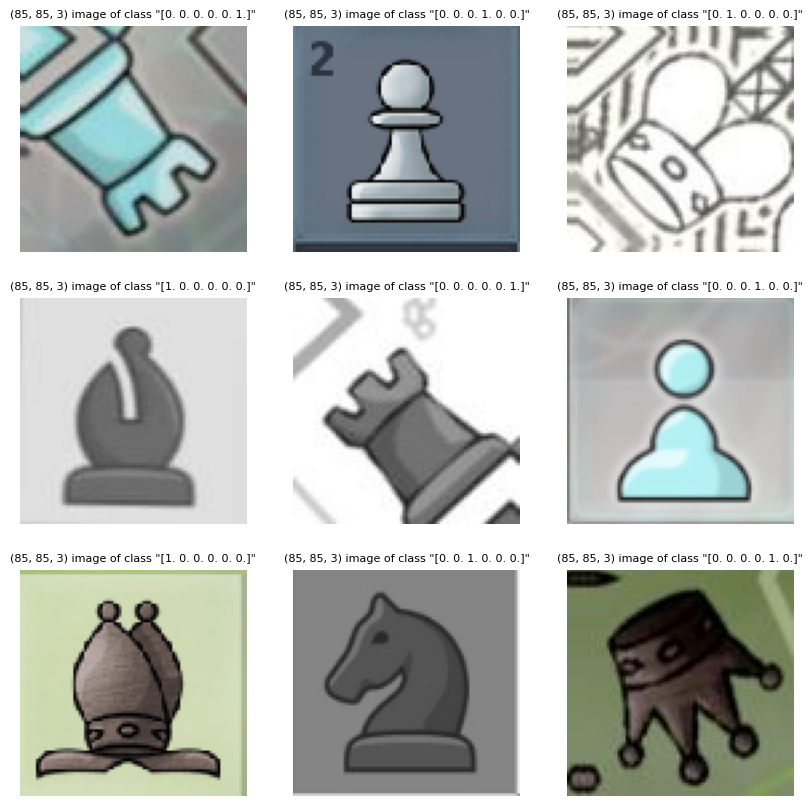

In [ ]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

show_sample_batch(ds_train)

Loads the testing data using the ``image_dataset_from_directory()`` function.

In [ ]:
ds_test = image_dataset_from_directory('/content/testing_data', 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 288 files belonging to 6 classes.


## 5. Convolutional neural networks (CNNs) in Keras
*   CNN - V2 



In [ ]:
learning_rate=0.001
input_shape = tuple(batch_x_train.shape)
input_shape

(64, 85, 85, 3)

CNN - V2

In [ ]:
# Architecture V2
cnn2 = Sequential([# The input layer
                   layers.Input(input_shape[1:]),    
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=16*input_shape[-1], kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=6, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2")
# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
#cnn2.build(input_shape)
# Check network
cnn2.summary()  # alternatively use tf.keras.utils.plot_model(cnn2, show_shapes=True)

Model: "CNN-V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 85, 85, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 81, 81, 18)        1368      
                                                                 
 activation (Activation)     (None, 81, 81, 18)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 48)        21648     
                                                                 
 activation_1 (Activation)   (None, 36, 36, 48)        0         
                                                            

Compiles and fits the model.

In [ ]:
# Compile the model
cnn2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])
# Model training 
epochs = 5
history2 = cnn2.fit(ds_train, epochs=epochs, validation_data=ds_val)

Epoch 1/5
15/15 [==============================] - 17s 1s/step - loss: 1.8611 - accuracy: 0.2225 - AUROC: 0.5518 - val_loss: 1.6873 - val_accuracy: 0.2707 - val_AUROC: 0.5837
Epoch 2/5
15/15 [==============================] - 14s 912ms/step - loss: 1.5153 - accuracy: 0.3828 - AUROC: 0.7313 - val_loss: 1.4976 - val_accuracy: 0.3712 - val_AUROC: 0.7437
Epoch 3/5
15/15 [==============================] - 15s 1s/step - loss: 1.3179 - accuracy: 0.4635 - AUROC: 0.8074 - val_loss: 1.4503 - val_accuracy: 0.3537 - val_AUROC: 0.7905
Epoch 4/5
15/15 [==============================] - 16s 1s/step - loss: 1.1451 - accuracy: 0.5409 - AUROC: 0.8605 - val_loss: 1.2526 - val_accuracy: 0.4629 - val_AUROC: 0.8238
Epoch 5/5
15/15 [==============================] - 16s 1s/step - loss: 1.1088 - accuracy: 0.5911 - AUROC: 0.8731 - val_loss: 1.7357 - val_accuracy: 0.3886 - val_AUROC: 0.7456


Plotting the Learning Curves 

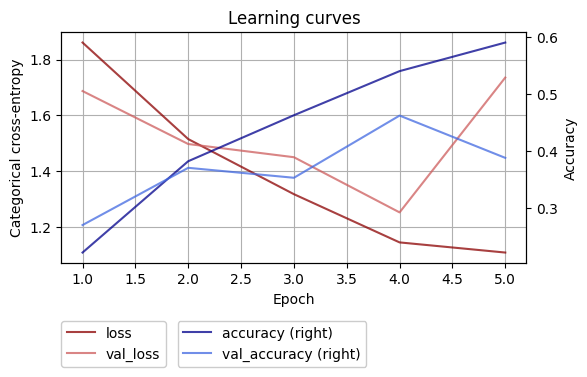

In [ ]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

**Conclusions:** at epoch 4 we have both cross-entropy less than 1.3 of and 54% of accuracy for the train dataset and 46% of accuracy for the validation dataset.


## 6. Hyperparameter search

We first perform a Hyperband, which uses a technique called successive halving, where it starts with a large number of randomly sampled hyperparameter configurations, trains them for a fixed number of epochs, and then discards the worst performing half. It repeats this process with the remaining configurations until only one configuration is left. This method can be much faster than GridSearch, especially for large hyperparameter spaces, as it discards unpromising configurations early on.

However we run this is hyperparameter search for the CNN-V2 but it was taking too much time. So we stopped the search after 2 hours of running. The same situation happen for the GridSearch. For this reason we will only apply the Random Search.

CNN-V2:

Defining the possible values for four hyperparameters: filters, kernel_size, learning_rate, and activation function.
Set the build model function adapting the CNN-V2 architecture.




In [ ]:
def build_model(hp):
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])
    input_shape = tuple(batch_x_train.shape)

    cnn2 = Sequential([
        layers.Input(input_shape[1:]),    
        layers.Rescaling(1./255),
        layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            kernel_initializer=initializers.GlorotNormal(seed=seed)
        ),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            kernel_initializer=initializers.GlorotNormal(seed=seed)
        ),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(), 
        layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=512, step=32),
                     activation=hp.Choice('dense_1_activation', values=['relu', 'sigmoid']),
                     kernel_initializer=initializers.GlorotNormal(seed=seed)),
        layers.Dense(units=6, activation="softmax",
                     kernel_initializer=initializers.GlorotNormal(seed=seed))
    ], name="CNN-V2")
    
    cnn2.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
                 metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    
    return cnn2


Apply the Random Search:

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='my_project'
)

tuner.search(ds_train, epochs=5, validation_data=ds_val)


The Random Seach improve the validation accuracy in 4% from 46% to 50%

Retrieve the best model:

In [ ]:
tuner.get_best_models(num_models=1)

## Transfer Learning

Transfer learning is a technique in deep learning where a pre-trained model is used as the starting point for a new task. It allows us to leverage the knowledge learned from a large dataset to a new dataset with a similar problem.

In [ ]:
# load the best model obtained from model tuning
best_model = tuner.get_best_models(num_models=1)[0]

# freeze the pre-trained layers so that they are not trained again
for layer in best_model.layers:
    layer.trainable = False

# create a new model on top of the pre-trained model
model = Sequential()
model.add(best_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=learning_rate),
              loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(ds_train, epochs=10, validation_data=ds_val)

# evaluate the model on the test data
score = model.evaluate(ds_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
15/15 [==============================] - 15s 976ms/step - loss: 1.7055 - accuracy: 0.4624 - val_loss: 1.6461 - val_accuracy: 0.4672
Epoch 2/10
15/15 [==============================] - 12s 779ms/step - loss: 1.5905 - accuracy: 0.5703 - val_loss: 1.5520 - val_accuracy: 0.5153
Epoch 3/10
15/15 [==============================] - 11s 737ms/step - loss: 1.4916 - accuracy: 0.5911 - val_loss: 1.4701 - val_accuracy: 0.5502
Epoch 4/10
15/15 [==============================] - 9s 592ms/step - loss: 1.4060 - accuracy: 0.6052 - val_loss: 1.3944 - val_accuracy: 0.5459
Epoch 5/10
15/15 [==============================] - 9s 594ms/step - loss: 1.3301 - accuracy: 0.5911 - val_loss: 1.3389 - val_accuracy: 0.5459
Epoch 6/10
15/15 [==============================] - 12s 766ms/step - loss: 1.2690 - accuracy: 0.6052 - val_loss: 1.2900 - val_accuracy: 0.5677
Epoch 7/10
15/15 [==============================] - 9s 590ms/step - loss: 1.2212 - accuracy: 0.6118 - val_loss: 1.2526 - val_accuracy: 0.5808
Ep

Concluding, our final model can predict with 51% of accuracy our test data identifying the 6 different chess pieces.

## References excluding the Course References

Gupta, J., Pathak, S., & Kumar, G. (2022). Deep Learning (CNN) and Transfer Learning: A Review. Journal of Physics: Conference Series, 2273(1), 012029. doi: 10.1088/1742-6596/2273/1/012029.

R. Ribani and M. Marengoni, "A Survey of Transfer Learning for Convolutional Neural Networks," 2019 32nd SIBGRAPI Conference on Graphics, Patterns and Images Tutorials (SIBGRAPI-T), Rio de Janeiro, Brazil, 2019, pp. 47-57, doi: 10.1109/SIBGRAPI-T.2019.00010.

Zheng Y, Huang J, Chen T, Ou Y and Zhou W (2021) Transfer of Learning in the Convolutional Neural Networks on Classifying Geometric Shapes Based on Local or Global Invariants. Front. Comput. Neurosci. 15:637144.doi: 10.3389/fncom.2021.637144

Garg, T., Garg, M., Mahela, O. P., & Garg, A. R. (2020). Convolutional Neural Networks with Transfer Learning for Recognition of COVID-19: A Comparative Study of Different Approaches. AI, 1(4), 586-606. doi: 10.3390/ai1040034.